In [1]:
import pandas as pd
from datetime import datetime
import os
pd.set_option('display.max_columns', None)
import numpy as np
import xgboost as xgb
#import matplotlib.pyplot as plt
#import seaborn as sns
import math

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split

from sklearn.metrics import accuracy_score, precision_score, precision_recall_curve, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from python_scripts.model_performance import generate_df_summary, predict_max_f1
# import feature data types
import json
with open('python_scripts/data_types.json') as f:
    data_types = json.load(f) 

import joblib

## Baseline Model

In [2]:
X_train = pd.read_csv('data/X_train.csv')
y_train = pd.read_csv('data/y_train.csv')
X_val = pd.read_csv('data/X_val.csv')
y_val = pd.read_csv('data/y_val.csv')

In [ ]:
baseline_model = XGBClassifier(
    eval_metric='auc',
    random_state=0
)

baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_val)

generate_df_summary(baseline_model, y_val, y_pred, 'baseline model')

In [ ]:
y_pred, best_threshold = predict_max_f1(baseline_model, X_val, y_val)
generate_df_summary(baseline_model, y_val, y_pred, 'baseline model threshold optimised', threshold=best_threshold)

## Oversampled datasets

In [ ]:
X_train_resampled_10 = pd.read_csv('data/resampled/X_train_10.csv')
y_train_resampled_10 = pd.read_csv('data/resampled/y_train_10.csv')

X_train_resampled_25 = pd.read_csv('data/resampled/X_train_25.csv')
y_train_resampled_25 = pd.read_csv('data/resampled/y_train_25.csv')

X_train_resampled_50 = pd.read_csv('data/resampled/X_train_50.csv')
y_train_resampled_50 = pd.read_csv('data/resampled/y_train_50.csv')

X_train_resampled_100 = pd.read_csv('data/resampled/X_train_100.csv')
y_train_resampled_100 = pd.read_csv('data/resampled/y_train_100.csv')

### 10:1 oversampling ratio

In [ ]:
baseline_model_10 = XGBClassifier(
    eval_metric='auc',
    random_state=0
)

baseline_model_10.fit(X_train_resampled_10, y_train_resampled_10)
y_pred = baseline_model_10.predict(X_val)
generate_df_summary(baseline_model_10, y_val, y_pred, 'baseline model with 10:1 resampling')

In [ ]:
y_pred, best_threshold = predict_max_f1(baseline_model_10, X_val, y_val)
generate_df_summary(baseline_model_10, y_val, y_pred, 'baseline model with 10:1 resampling threshold optimised', threshold=best_threshold)

### 4:1 oversampling ratio

In [ ]:
baseline_model_25 = XGBClassifier(
    eval_metric='auc',
    random_state=0
)

baseline_model_25.fit(X_train_resampled_25, y_train_resampled_25)
y_pred = baseline_model_25.predict(X_val)
generate_df_summary(baseline_model_25, y_val, y_pred, 'baseline model with 4:1 resampling')

In [ ]:
y_pred, best_threshold = predict_max_f1(baseline_model_25, X_val, y_val)
generate_df_summary(baseline_model_25, y_val, y_pred, 'baseline model with 4:1 resampling threshold optimised', threshold=best_threshold)

### 2:1 oversampling ratio

In [ ]:
baseline_model_50 = XGBClassifier(
    eval_metric='auc',
    random_state=0
)

baseline_model_50.fit(X_train_resampled_50, y_train_resampled_50)
y_pred = baseline_model_50.predict(X_val)
generate_df_summary(baseline_model_50, y_val, y_pred, 'baseline model with 2:1 resampling')

In [ ]:
y_pred, best_threshold = predict_max_f1(baseline_model_50, X_val, y_val)
generate_df_summary(baseline_model_50, y_val, y_pred, 'baseline model with 2:1 resampling threshold optimised', threshold=best_threshold)

### 1:1 oversampling ratio

In [ ]:
baseline_model_100 = XGBClassifier(
    eval_metric='auc',
    random_state=0
)

baseline_model_100.fit(X_train_resampled_100, y_train_resampled_100)
y_pred = baseline_model_100.predict(X_val)
generate_df_summary(baseline_model_50, y_val, y_pred, 'baseline model with 1:1 resampling')

In [ ]:
y_pred, best_threshold = predict_max_f1(baseline_model_100, X_val, y_val)
generate_df_summary(baseline_model_100, y_val, y_pred, 'baseline model with 1:1 resampling threshold optimised', threshold=best_threshold)

### Comparing baseline model performance

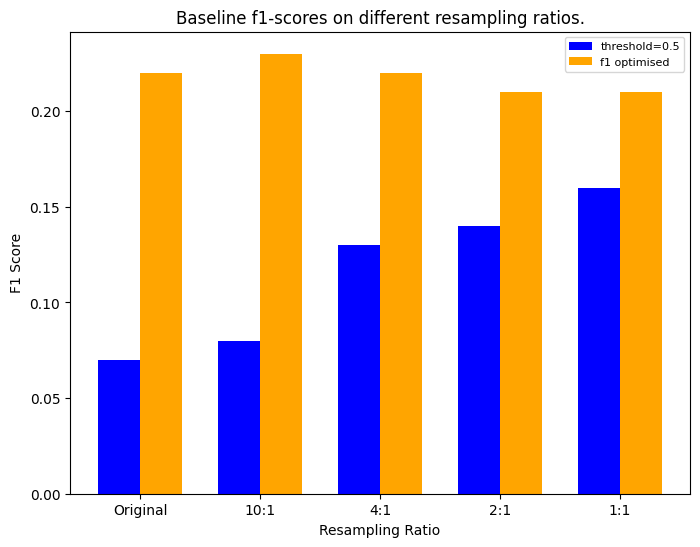

In [2]:
mp_df = pd.read_csv('output/model_performance.csv')

ratios = ['Original', '10:1', '4:1', '2:1', '1:1']
f1s = mp_df['F1-Score'][::2].values[:5]
f1s_optimised = mp_df['F1-Score'][1::2].values[:5]

bar_width = 0.35  
x = np.arange(len(ratios)) 

plt.figure(figsize=(8, 6))
plt.bar(x - bar_width/2, f1s, bar_width, label='threshold=0.5', color='blue')
plt.bar(x + bar_width/2, f1s_optimised, bar_width, label='f1 optimised', color='orange')
plt.xlabel('Resampling Ratio')
plt.ylabel('F1 Score')
plt.title('Baseline f1-scores on different resampling ratios.')
plt.xticks(ticks=x, labels=ratios) 
plt.legend(fontsize=8)
plt.show()


## Hyper parameter tuning

### Deep dive with more combinations and WITHOUT smote, using xgboost inbuild scale_pos_weight parameter

In [ ]:
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic', 
    eval_metric='auc'
)

# inital param search
param_dist = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],  
    'max_depth': [3, 4, 5, 6, 8, 10], 
    'min_child_weight': [1, 3, 5, 7],
    'reg_lambda': [0.1, 1, 10, 100], 
    'reg_alpha': [0, 0.1, 1, 10],  
    'scale_pos_weight': [10, 25, 50, 75, 99],  
    'max_delta_step': [0, 1, 5, 10],  
    'gamma': [0, 0.1, 0.5, 1, 5],  
    'subsample': [0.5, 0.7, 0.8, 1.0],  
    'colsample_bytree': [0.5, 0.7, 0.9, 1.0],  

    'n_estimators': [1000],
    'early_stopping_rounds': [15],
}


# RandomizedSearchCV setup for parameter tuning
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50, 
    scoring='average_precision',  
    cv=3,  
    verbose=0,  
    random_state=0
)

# Fit the model (train and tune hyperparameters)
random_search.fit(X_train, y_train, 
                  eval_set=[(X_val, y_val)])

# Get the best model and print the results
best_model = random_search.best_estimator_

# Predictions and evaluation
y_pred = best_model.predict(X_val)

In [ ]:
generate_df_summary(best_model, y_val, y_pred, 'randomized search no smote')

In [ ]:
y_pred, best_threshold = predict_max_f1(best_model, X_val, y_val)
generate_df_summary(best_model, y_val, y_pred, 'randomized search no smote threshold optimised', threshold=best_threshold)

In [ ]:
# create directory to store all 50 models from randomised search on non oversampled training set
os.makedirs("saved_models/smote_no_oversampling_1", exist_ok=True)

# save each trained model
for i in range(len(random_search.cv_results_["params"])):
    trained_model = random_search.best_estimator_.set_params(**random_search.cv_results_["params"][i])
    filename = f"saved_models/smote_no_oversampling_1/model_rank_{random_search.cv_results_['rank_test_score'][i]}.pkl"
    joblib.dump(trained_model, filename)
print("All trained models have been saved successfully.")

# save results too
results_df = pd.DataFrame(random_search.cv_results_)
results_df = results_df.sort_values('rank_test_score').reset_index(drop=True)
results_df.to_csv('saved_models/smote_no_oversampling_1/results.csv')
print("Model results have been saved successfully.")

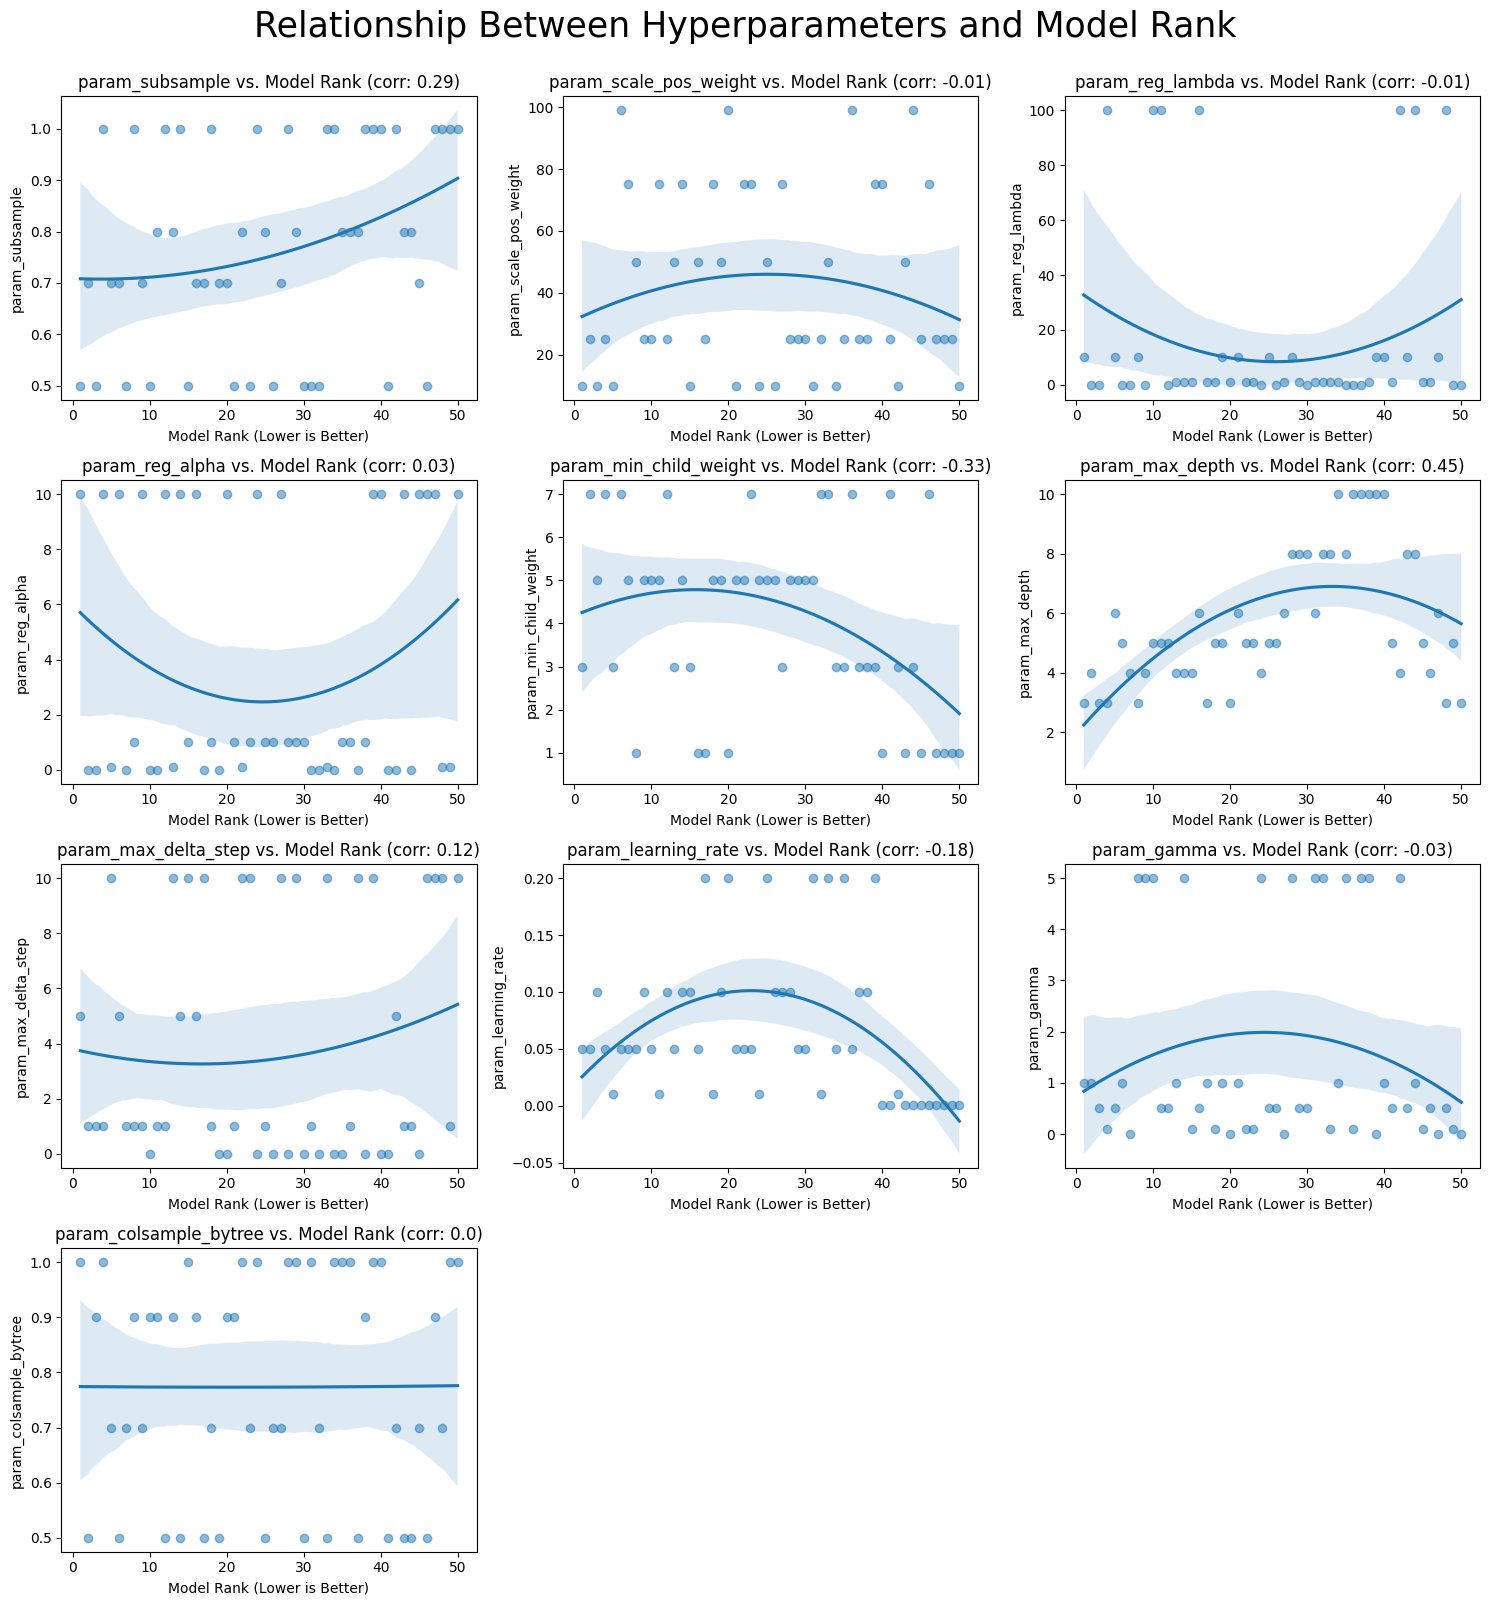

In [36]:
results_df = pd.read_csv('saved_models/smote_no_oversampling_1/results.csv')
to_analyse = ['param_subsample', 'param_scale_pos_weight',
       'param_reg_lambda', 'param_reg_alpha',
       'param_min_child_weight', 'param_max_depth', 'param_max_delta_step',
       'param_learning_rate', 'param_gamma', 'param_colsample_bytree']

# subplots
num_vars = len(to_analyse)
cols = 3 
rows = math.ceil(num_vars / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))
axes = axes.flatten()

for i, param in enumerate(to_analyse):
    sns.regplot(x=results_df["rank_test_score"], 
                y=results_df[param], 
                order=2,  
                scatter_kws={'alpha': 0.5},  
                ax=axes[i])  # plot in respective subplot

    # correlation
    correlation = round(results_df[param].corr(results_df["rank_test_score"]), 2)

    axes[i].set_xlabel("Model Rank (Lower is Better)")
    axes[i].set_ylabel(param)
    axes[i].set_title(f"{param} vs. Model Rank (corr: {correlation})")

# remove spares subplts
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
fig.suptitle("Relationship Between Hyperparameters and Model Rank", fontsize=25, y=1)
plt.tight_layout()
plt.show()


In [3]:
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic', 
    eval_metric='auc'
)

# inital param search
param_dist = {
    'learning_rate': [0.03, 0.04, 0.05, 0.06, 0.07],  
    'max_depth': [2, 3, 4, 5, 6], 
    'min_child_weight': [3, 4, 5, 6],
    'reg_lambda': [10, 20, 30, 40], 
    'reg_alpha': [0.1, 2.5, 5, 10],  
    'scale_pos_weight': [5, 10, 15, 20, 25],  
    'max_delta_step': [3, 4, 5, 6, 7],  
    'gamma': [0.5, 1, 2, 3],  
    'subsample': [0.4, 0.5, 0.6, 0.7],  
    'colsample_bytree': [0.3, 0.5, 0.7, 0.9],  

    'n_estimators': [1000],
    'early_stopping_rounds': [15],
}


# RandomizedSearchCV setup for parameter tuning
random_search_2 = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50, 
    scoring='average_precision',  
    cv=3,  
    verbose=0,  
    random_state=0
)

# Fit the model (train and tune hyperparameters)
random_search_2.fit(X_train, y_train, 
                  eval_set=[(X_val, y_val)])

# Get the best model and print the results
best_model = random_search_2.best_estimator_

# Predictions and evaluation
y_pred = best_model.predict(X_val)

[0]	validation_0-auc:0.73078
[1]	validation_0-auc:0.77613
[2]	validation_0-auc:0.82554
[3]	validation_0-auc:0.83151
[4]	validation_0-auc:0.83175
[5]	validation_0-auc:0.83555
[6]	validation_0-auc:0.83594
[7]	validation_0-auc:0.83438
[8]	validation_0-auc:0.84237
[9]	validation_0-auc:0.84839
[10]	validation_0-auc:0.84889
[11]	validation_0-auc:0.85174
[12]	validation_0-auc:0.85411
[13]	validation_0-auc:0.85315
[14]	validation_0-auc:0.85493
[15]	validation_0-auc:0.85659
[16]	validation_0-auc:0.85719
[17]	validation_0-auc:0.85850
[18]	validation_0-auc:0.85928
[19]	validation_0-auc:0.85939
[20]	validation_0-auc:0.85880
[21]	validation_0-auc:0.86015
[22]	validation_0-auc:0.86089
[23]	validation_0-auc:0.86154
[24]	validation_0-auc:0.86230
[25]	validation_0-auc:0.86314
[26]	validation_0-auc:0.86335
[27]	validation_0-auc:0.86481
[28]	validation_0-auc:0.86603
[29]	validation_0-auc:0.86538
[30]	validation_0-auc:0.86516
[31]	validation_0-auc:0.86584
[32]	validation_0-auc:0.86595
[33]	validation_0-au

In [4]:
generate_df_summary(best_model, y_val, y_pred, 'randomized search round 2 no smote')

Precision: 0.31
Recall: 0.15
F1-Score: 0.2

Confusion Matrix:

               Pred Class 0  Pred Class 1
True Class 0        106227           491
True Class 1          1229           221


In [5]:
y_pred, best_threshold = predict_max_f1(best_model, X_val, y_val)
generate_df_summary(best_model, y_val, y_pred, 'randomized search round 2 no smote threshold optimised', threshold=best_threshold)

Precision: 0.24
Recall: 0.25
F1-Score: 0.25

Confusion Matrix:

               Pred Class 0  Pred Class 1
True Class 0        105583          1135
True Class 1          1082           368


In [6]:
# create directory to store all 50 models from randomised search on non oversampled training set
os.makedirs("saved_models/smote_no_oversampling_2", exist_ok=True)

# save each trained model
for i in range(len(random_search_2.cv_results_["params"])):
    trained_model = random_search_2.best_estimator_.set_params(**random_search_2.cv_results_["params"][i])
    filename = f"saved_models/smote_no_oversampling_2/model_rank_{random_search_2.cv_results_['rank_test_score'][i]}.pkl"
    joblib.dump(trained_model, filename)
print("All trained models have been saved successfully.")

# save results too
results_df = pd.DataFrame(random_search_2.cv_results_)
results_df = results_df.sort_values('rank_test_score').reset_index(drop=True)
results_df.to_csv('saved_models/smote_no_oversampling_2/results.csv')
print("Model results have been saved successfully.")

All trained models have been saved successfully.
Model results have been saved successfully.


In [10]:
p = pd.read_csv('output/model_performance.csv')

In [17]:
p[-6:]

,Name,Date,Precision,Recall,F1-Score,True Negatives,False Positives,False Negatives,True Positives,objective,base_score,booster,callbacks,colsample_bylevel,colsample_bynode,colsample_bytree,device,early_stopping_rounds,enable_categorical,eval_metric,feature_types,gamma,grow_policy,importance_type,interaction_constraints,learning_rate,max_bin,max_cat_threshold,max_cat_to_onehot,max_delta_step,max_depth,max_leaves,min_child_weight,missing,monotone_constraints,multi_strategy,n_estimators,n_jobs,num_parallel_tree,random_state,reg_alpha,reg_lambda,sampling_method,scale_pos_weight,subsample,tree_method,validate_parameters,verbosity,proba_threshold
9,baseline model with 1:1 resampling threshold o...,2025-03-05,0.16,0.30,0.21,104408,2310,1019,431,binary:logistic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,auc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.224884
10,randomized search no smote,2025-03-06,0.22,0.28,0.24,105280,1438,1050,400,binary:logistic,NaN,NaN,NaN,NaN,NaN,1.0,NaN,15.0,False,auc,NaN,1.0,NaN,NaN,NaN,0.05,NaN,NaN,NaN,5.0,3.0,NaN,3.0,NaN,NaN,NaN,1000.0,NaN,NaN,NaN,10.0,10.0,NaN,10.0,0.5,NaN,NaN,NaN,0.500000
11,randomized search no smote threshold optimised,2025-03-06,0.24,0.26,0.25,105504,1214,1074,376,binary:logistic,NaN,NaN,NaN,NaN,NaN,1.0,NaN,15.0,False,auc,NaN,1.0,NaN,NaN,NaN,0.05,NaN,NaN,NaN,5.0,3.0,NaN,3.0,NaN,NaN,NaN,1000.0,NaN,NaN,NaN,10.0,10.0,NaN,10.0,0.5,NaN,NaN,NaN,0.528227
12,randomized search no smote,2025-03-06,0.24,0.26,0.25,105504,1214,1074,376,binary:logistic,NaN,NaN,NaN,NaN,NaN,0.9,NaN,15.0,False,auc,NaN,0.5,NaN,NaN,NaN,0.05,NaN,NaN,NaN,5.0,6.0,NaN,1.0,NaN,NaN,NaN,1000.0,NaN,NaN,NaN,10.0,100.0,NaN,50.0,0.7,NaN,NaN,NaN,0.500000
13,randomized search round 2 no smote,2025-03-06,0.31,0.15,0.20,106227,491,1229,221,binary:logistic,NaN,NaN,NaN,NaN,NaN,0.3,NaN,15.0,False,auc,NaN,2.0,NaN,NaN,NaN,0.04,NaN,NaN,NaN,3.0,3.0,NaN,6.0,NaN,NaN,NaN,1000.0,NaN,NaN,NaN,2.5,30.0,NaN,5.0,0.5,NaN,NaN,NaN,0.500000
14,randomized search round 2 no smote threshold o...,2025-03-06,0.24,0.25,0.25,105583,1135,1082,368,binary:logistic,NaN,NaN,NaN,NaN,NaN,0.3,NaN,15.0,False,auc,NaN,2.0,NaN,NaN,NaN,0.04,NaN,NaN,NaN,3.0,3.0,NaN,6.0,NaN,NaN,NaN,1000.0,NaN,NaN,NaN,2.5,30.0,NaN,5.0,0.5,NaN,NaN,NaN,0.365522


### Deep dive this time using SMOTE data sets

In [ ]:
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic', 
    eval_metric='aucpr',
)

# Define the hyperparameters to search
param_dist = {
    'learning_rate': np.linspace(0.01, 0.1, 10),
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'reg_lambda': [0, 0.1, 1, 10, 100], #l2
    'reg_alpha': [0, 0.1, 1, 10, 100],  # l1
    'n_estimators': [1000],
    'early_stopping_rounds': [15],
    # 'scale_pos_weight': [scale_pos_weight_1], #only using 1 for now
    'max_delta_step': [0, 1, 5, 10],
    'gamma': [0, 0.1, 0.5, 1, 2]
}

# RandomizedSearchCV setup for parameter tuning
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20, 
    scoring='average_precision',  
    cv=3,  
    verbose=1,  
    random_state=0
)

# Fit the model (train and tune hyperparameters)
random_search.fit(X_train_resampled, y_train_resampled, 
                  eval_set=[(X_val, y_val)])

# Get the best model and print the results
best_model = random_search.best_estimator_

# Predictions and evaluation
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
generate_df_summary(best_model, y_test, y_pred, 'randomized search with smote')

In [ ]:
results_df = pd.DataFrame(random_search.cv_results_)
results_df.sort_values('rank_test_score', ascending=True).reset_index(drop=True).head()

### modifications:
- Using balanced dataset with SMOTE and experimenting with some small values of `scale_pos_weight`
- Adjusting param_dist (see comments)

In [ ]:
np.linspace(0.01, 0.25, 13)

In [ ]:
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic', 
    eval_metric='aucpr'
)

# set scale_pos_weight values
scale_pos_weight_1 = (len(y_train) - y_train.fraud_bool.sum()) / y_train.fraud_bool.sum()
scale_pos_weight_2 = np.sqrt((len(y_train) - y_train.fraud_bool.sum()) / y_train.fraud_bool.sum())
scale_pos_weight_3 = np.mean([scale_pos_weight_1, scale_pos_weight_2])
scale_pos_weight_4 = scale_pos_weight_2 / 2

# Define the hyperparameters to search
param_dist = {
    'learning_rate': np.linspace(0.01, 0.25, 13), # wider range
    'max_depth': [3, 5, 7, 9, 11], # added 11
    'min_child_weight': [1, 3, 5, 7], # added 7
    'reg_lambda': [0, 0.1, 1, 10, 100, 200], #l2 added 200
    'reg_alpha': [0, 0.1, 1, 10, 100, 200],  # l1 added 200
    'n_estimators': [1000],
    'early_stopping_rounds': [15],
    'scale_pos_weight': [scale_pos_weight_2, scale_pos_weight_4, 1], # ~[9, 4.5, 1]
    'max_delta_step': [0, 1, 5, 10, 20], # added 20
    'gamma': [0, 0.1, 0.5, 1, 2, 5, 10] # wider range
}

# RandomizedSearchCV setup for parameter tuning
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=35, 
    scoring='average_precision',  
    cv=3,  
    verbose=0,  
    random_state=0
)

# Fit the model (train and tune hyperparameters)
random_search.fit(X_train_resampled, y_train_resampled, 
                  eval_set=[(X_val, y_val)])

# Get the best model and print the results
best_model = random_search.best_estimator_

# Predictions and evaluation
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
generate_df_summary(best_model, y_test, y_pred, 'randomized search with smote and scale_pos_weight')

In [ ]:
results_df = pd.DataFrame(random_search.cv_results_)
results_df.sort_values('rank_test_score', ascending=True).reset_index(drop=True).head()

### modifications:
- Using reduced balanced dataset with SMOTE now using ratio of 10:1 negative:positive fraud combined with `scale_pos_weight`
- Adjusting param_dist (see comments)

In [ ]:
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic', 
    eval_metric='aucpr'
)

# Define the hyperparameters to search
param_dist = {
    'learning_rate': np.linspace(0.01, 0.25, 13), # wider range
    'max_depth': [3, 5, 7, 9, 11], # added 11
    'min_child_weight': [1, 3, 5, 7], # added 7
    'reg_lambda': [0, 0.1, 1, 10, 100, 200], #l2 added 200
    'reg_alpha': [0, 0.1, 1, 10, 100, 200],  # l1 added 200
    'n_estimators': [1000],
    'early_stopping_rounds': [15],
    'scale_pos_weight': [5, 10, 20, 30],
    'max_delta_step': [0, 1, 5, 10, 20], # added 20
    'gamma': [0, 0.1, 0.5, 1, 2, 5, 10] # wider range
}

# RandomizedSearchCV setup for parameter tuning
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=35, 
    scoring='average_precision',  
    cv=3,  
    verbose=0,  
    random_state=0
)

# Fit the model (train and tune hyperparameters)
random_search.fit(X_train_resampled, y_train_resampled, 
                  eval_set=[(X_val, y_val)])

# Get the best model and print the results
best_model = random_search.best_estimator_

# Predictions and evaluation
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
generate_df_summary(best_model, y_test, y_pred, 'randomized search with smote and scale_pos_weight')

In [ ]:
results_df = pd.DataFrame(random_search.cv_results_)
results_df.sort_values('rank_test_score', ascending=True).reset_index(drop=True).head()

In [ ]:
# rename 'randomized search with smote and scale_pos_weight'